# The Urban Air Pollution Challenge

In this notebook we use machine learning to tackle the [Zindi Urban Air Pollution Challenge](https://zindi.africa/competitions/zindiweekendz-learning-urban-air-pollution-challenge):

<blockquote> 
The objective of this challenge is to predict PM2.5 particulate matter concentration in the air every day for each city. 

```PM2.5``` refers to atmospheric particulate matter that have a diameter of less than 2.5 micrometers and is one of the most harmful air pollutants. ```PM2.5``` is a common measure of air quality that normally requires ground-based sensors to measure. The data covers the last three months, spanning hundreds of cities across the globe.

The data comes from three main sources:

- Ground-based air quality sensors. These measure the target variable (PM2.5 particle concentration). In addition to the target column (which is the daily mean concentration) there are also columns for minimum and maximum readings on that day, the variance of the readings and the total number (count) of sensor readings used to compute the target value. This data is only provided for the train set - you must predict the target variable for the test set.

- The Global Forecast System (GFS) for weather data. Humidity, temperature and wind speed, which can be used as inputs for your model.

- The Sentinel 5P satellite. This satellite monitors various pollutants in the atmosphere. For each pollutant, we queried the offline Level 3 (L3) datasets available in Google Earth Engine (you can read more about the individual products here: https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p). For a given pollutant, for example NO2, we provide all data from the Sentinel 5P dataset for that pollutant. This includes the key measurements like NO2_column_number_density (a measure of NO2 concentration) as well as metadata like the satellite altitude. We recommend that you focus on the key measurements, either the column_number_density or the tropospheric_X_column_number_density (which measures density closer to Earth’s surface).

Unfortunately, this data is not 100% complete. Some locations have no sensor readings for a particular day, and so those rows have been excluded. There are also gaps in the input data, particularly the satellite data for CH4.

</blockquote>

# Set up 
Here, we load the required packages and methods for the analyses we tried out. We also set some plotting and warning defaults, as well as a random seed for reproducibility. 

In [1]:
# Import packages and methods
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer #to be able to load the IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats

# Set defaults
sns.set_style('white')
sns.set_palette('magma')
warnings.filterwarnings('ignore')

# Set random seed
RSEED = 42

# Load training data
The data can be downloaded from the ```data``` tab on [Zindi](https://zindi.africa/competitions/zindiweekendz-learning-urban-air-pollution-challenge). If not done so already, move the files to ```ds-airpollution\data```. 

In [6]:
df = pd.read_csv('data/Train.csv')

# Exploratory Data Analysis (EDA)
We start with inspecting and summarizing the training data. 

In [ ]:
#Check column names
df.head()

In [ ]:
#Check size of the data frame
df.shape

In [ ]:
#Check number of missing values
df.isna().sum().sort_values(ascending=False)

# Missing data
Given the high number of missing data for some features, we ran a more detailed analysis of missing values to look for potential patterns. 

<Axes: >

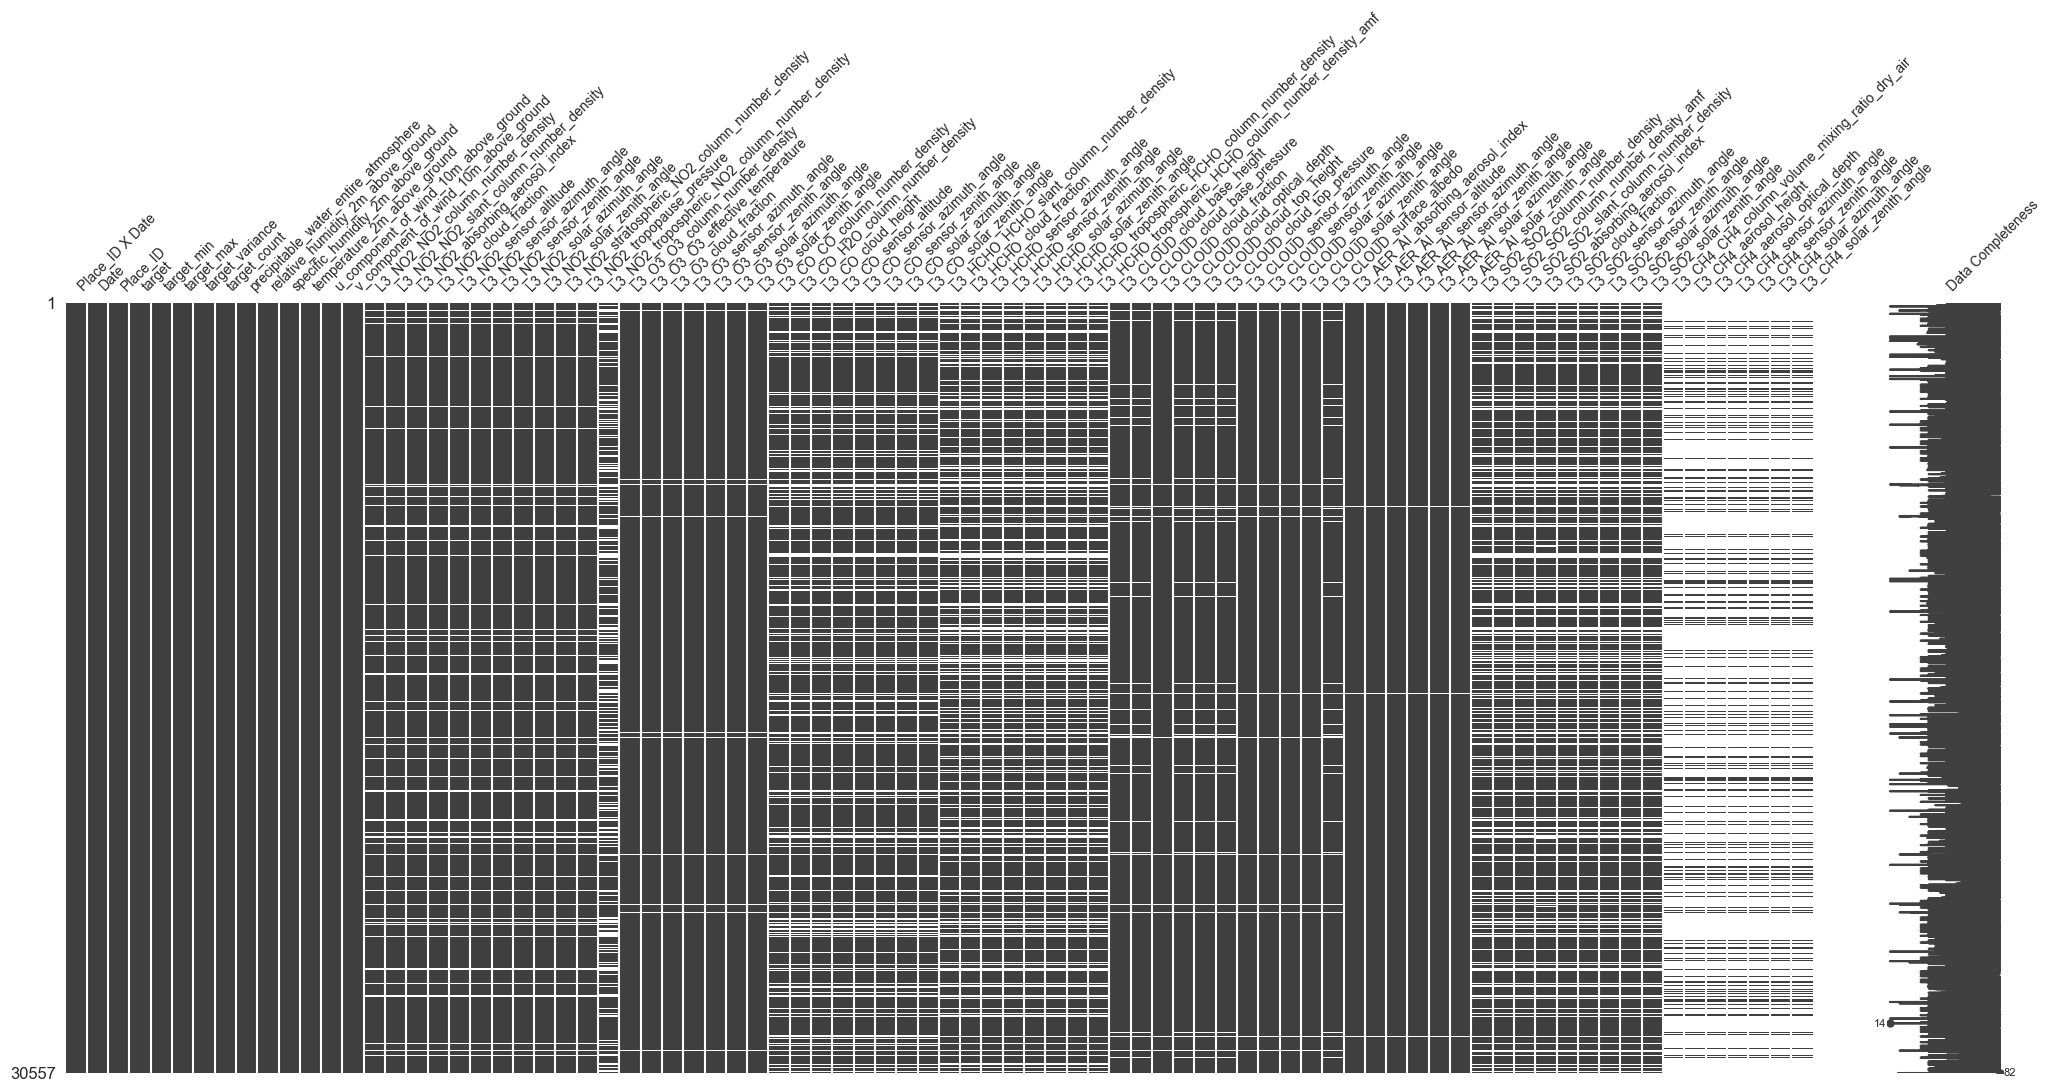

In [8]:
msno.matrix(df, fontsize=10,labels=True)

From the missingno matrix figure, it is clear that there is only missing data for the satellite data (with prefix ```L3```), not for the target or close-to-the-ground measurements. The amount of missing satellite data is  related to the type of pollutant, with only very sparse methane (```CHO4```) data.

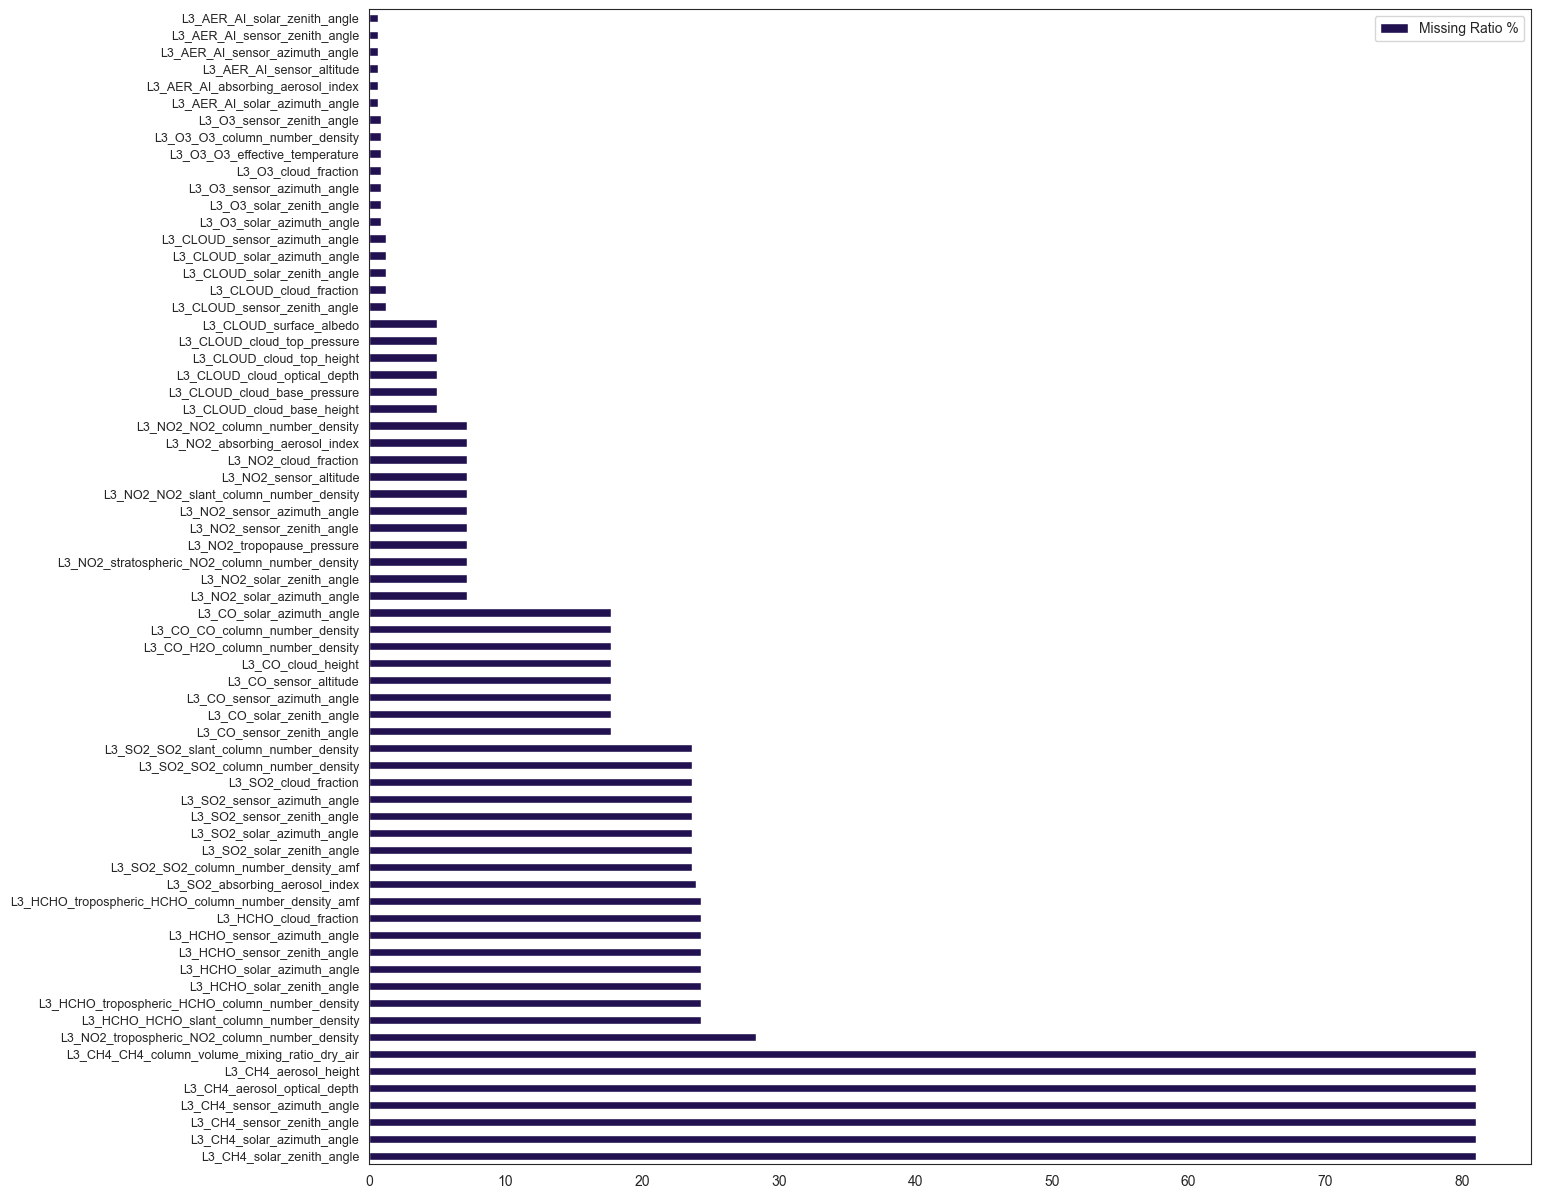

In [10]:
# plot percentage of missing instances with labels
# from: https://stackoverflow.com/questions/69537383/how-to-plot-count-of-null-values-for-each-column-in-pandas-dataframe
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)
plot_width, plot_height = (15,15)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
plt.rcParams['ytick.labelsize'] = 9

Looking at the percentages of missing data, we are missing over 80% data for methane (```CH4```). We will remove these columns from the data frame. 

In [7]:
# create a copy for cleaned data
df_clean = df.copy()

In [9]:
# drop CH4 columns
cols_ch4 = [col for col in df.columns if 'CH4' in col]
df_clean.drop(columns=cols_ch4, axis=1, inplace=True)

We also miss up to 25% for formaldehyde (```HCHO```) and sulferdioxide (```SO2```) and up to 20% for carbonmonoxide (```CO```), most nitrogen oxide measurements (```NO2```), cloud (```CLOUD```), ozone (```O3```), and aerosols (```AER```). Given the size of the dataset, we keep these features and impute missing data. 

# Check for outliers

In [ ]:
#removes 0 as outliers
variables_list_0_as_outlier = [
    "L3_NO2_NO2_column_number_density",
    "L3_NO2_NO2_slant_column_number_density",
    "L3_NO2_sensor_altitude",
    "L3_NO2_tropopause_pressure",
    "L3_NO2_solar_zenith_angle",
    "L3_SO2_SO2_column_number_density",
    "L3_SO2_SO2_column_number_density_amf",
    "L3_SO2_SO2_slant_column_number_density",
    "L3_SO2_solar_zenith_angle",
    "L3_O3_O3_column_number_density",
    "L3_O3_O3_effective_temperature",
    "L3_O3_solar_zenith_angle",
    "L3_CO_CO_column_number_density",
    "L3_CO_sensor_altitude",
    "L3_CO_solar_zenith_angle",
    "L3_HCHO_solar_zenith_angle",
    "L3_HCHO_tropospheric_HCHO_column_number_density_amf"
]

df_clean[variables_list_0_as_outlier].replace(0, np.nan, inplace=True)

In [ ]:

# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create integer column for weekends
df["IsWeek"] = (df["Date"].dt.weekday < 5).astype(int)

df.drop(columns=['Date', 'Place_ID', 'Place_ID X Date', 'target_min', 'target_max', 'target_variance', 'target_count'], axis=1, inplace=True)

df.head(5)

In [6]:
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## Pipeline

In [7]:
# Pipeline XGBoost Regression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb

features = list(X.columns)

num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, features),
])

pipe_xgbreg = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbreg', xgb.XGBRegressor(eta = 0.1, n_estimators=50,max_depth=10, colsample_bytree=0.8,gamma=5,reg_alpha=0,reg_lambda=10 )) 
])

pipe_xgbreg

  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['precipitable_water_entire_atmosphere',
                                                   'relative_humidity_2m_above_ground',
                                                   'specific_humidity_2m_above_ground',
                                                   'temperature_2m_above_ground',
                                                   'u_component_of_wind_10m_above_ground'...
                              eval_metric=None, feature_types=None, gamma=5,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=50,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


pipe_xgbreg.fit(X_train, y_train)

y_pred_test = pipe_xgbreg.predict(X_test)
y_pred_train = pipe_xgbreg.predict(X_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mse = mean_squared_error(y_train, y_pred_train)
rmse = mse ** 0.5
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
              
            
print(f"TEST: RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.3f}")
print(f"train: RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

TEST: RMSE: 29.85, MAE: 19.80, R²: 0.595
train: RMSE: 20.07, MAE: 13.07, R²: 0.816


# GRIDSEARCH Finetuning

In [9]:
#GRIDSEARCH

param_xgbreg_grid = {
              'xgbreg__n_estimators': [50],
              'xgbreg__learning_rate': [0.1], 
              'xgbreg__max_depth': [10],
              'xgbreg__colsample_bytree': [0.8],
              'xgbreg__gamma': [5],
              'xgbreg__reg_alpha': [0],
              'xgbreg__reg_lambda': [10]
            }

grid_search_xbreg = GridSearchCV(pipe_xgbreg, param_grid=param_xgbreg_grid, cv=5, scoring='neg_mean_absolute_error', 
                           verbose=1, n_jobs=-1)

grid_search_xbreg.fit(X_train, y_train)
grid_search_xbreg.best_params_, grid_search_xbreg.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


({'xgbreg__colsample_bytree': 0.8,
  'xgbreg__gamma': 5,
  'xgbreg__learning_rate': 0.1,
  'xgbreg__max_depth': 10,
  'xgbreg__n_estimators': 50,
  'xgbreg__reg_alpha': 0,
  'xgbreg__reg_lambda': 10},
 -20.04695228283282)

In [10]:
# best_model = grid_search_xbreg.best_estimator_
# y_test_predicted_grid = best_model.predict(X_test)
# y_train_predicted_grid = best_model.predict(X_train)

# print("mean_absolute_error: {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_grid)))
# print("mean_absolute_error_train: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_grid)))

# Error Analyse

In [11]:
error = np.abs(y_pred_train - y_train)

In [12]:


df_erroranalyse = X_train.copy()
df_erroranalyse['y_true'] = y_train
df_erroranalyse['y_pred'] = y_pred_train
df_erroranalyse['abs_error'] = error
df_erroranalyse["rel_error"] = error/y_pred_train#df_erroranalyse["y_true"]

In [13]:
df_erroranalyse.fillna(df.median(),inplace=True)

In [14]:
top_fehler = df_erroranalyse.sort_values(by='abs_error', ascending=False).head(10)


In [17]:
best_model = grid_search_xbreg.best_estimator_
reg = best_model.named_steps['xgbreg']
importances = reg.feature_importances_
feature_names = X_train.columns

best_feature=list(feature_names[importances>0.04])
lst=['y_true','y_pred','abs_error','rel_error']
best_feature.extend(lst)

# best_feature

# sns.pairplot(data=df_erroranalyse[best_feature])


## JULIAs Add

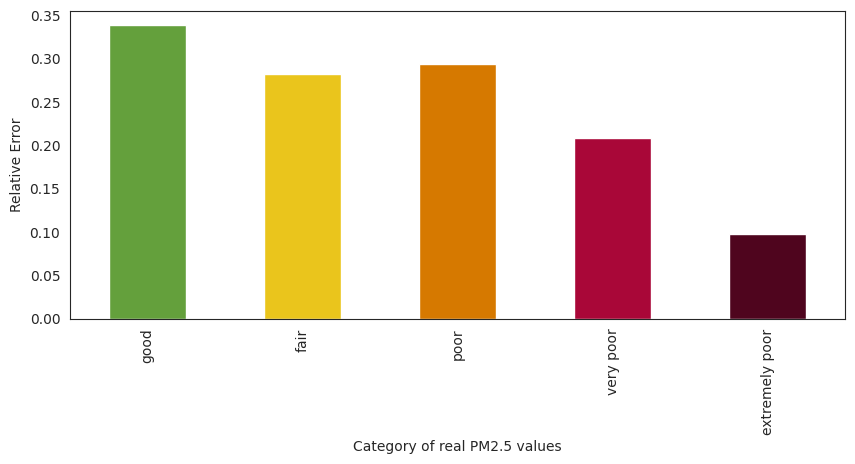

In [18]:
#from violinplot import plot_hist


colors = ['#64a03c', '#eac51c', '#d67900', '#a90738', '#4f051e']

df_for_violinplot = df_erroranalyse.copy()
bins = [0, 12.5, 25, 50, 150, np.inf]
health_cat = ['good', 'fair','poor','very poor','extremely poor']
df_for_violinplot['target_cat'] = pd.cut(df['target'], bins, labels = health_cat)
df_for_violinplot['target_cat_pred'] = pd.cut(df_for_violinplot['y_pred'], bins, labels = health_cat)

error_per_cathegory = df_for_violinplot.groupby('target_cat')['rel_error'].mean()
error_per_cathegory_pred = df_for_violinplot.groupby('target_cat_pred')['rel_error'].mean()


# error_per_cathegory.plot(kind='bar', figsize=(10, 4), color=colors)
error_per_cathegory_pred.plot(kind='bar', figsize=(10, 4), color=colors)

plt.xlabel('Category of real PM2.5 values')
plt.ylabel('Relative Error')


plt.subplots_adjust(hspace=2.4)  



# df_errors = pd.DataFrame({
#     'true cat': error_per_cathegory,
#     'predicted cat': error_per_cathegory_pred
# })
# df_errors = df_errors.sort_index()
# df_errors.plot(kind='bar', figsize=(12, 5), color=['#2EA8FF', '#2DFFCC'])



Text(0, 0.5, 'target')

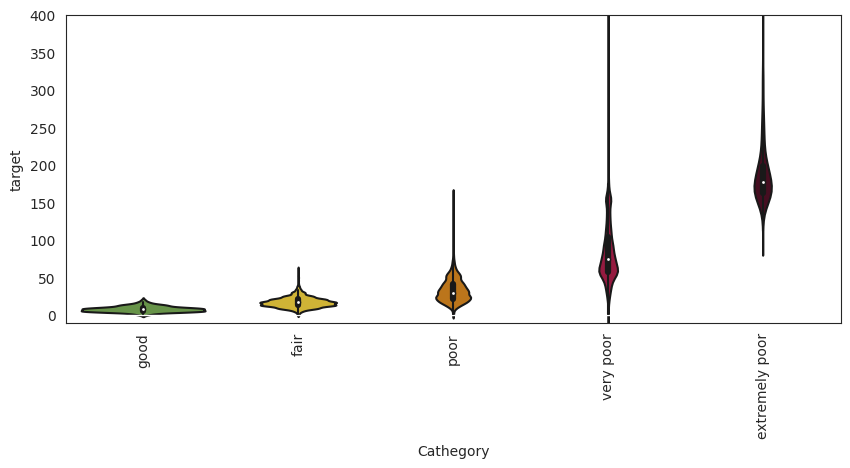

In [19]:
plt.figure(figsize=(12, 6))

sns.violinplot(x='target_cat_pred', y='y_true', data=df_for_violinplot, palette=colors)
# sns.violinplot(x='target_cat', y='y_pred', data=df_for_violinplot, palette=colors)

error_per_cathegory_pred.plot(kind='bar', figsize=(10, 4), color=colors)


plt.ylim(-10, 400)
plt.xlabel('Cathegory')
plt.ylabel('target')


Text(0, 0.5, 'True PM2.5 concentration')

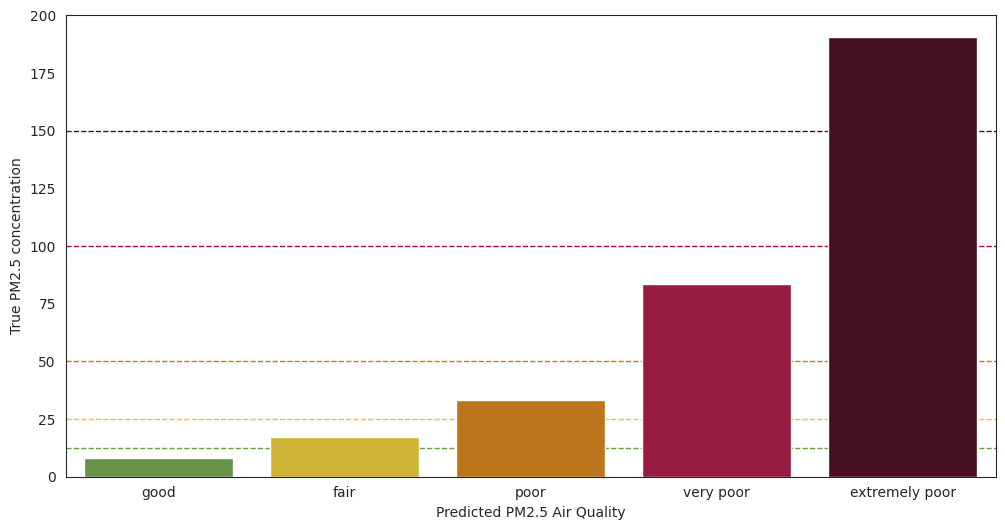

In [20]:
mean_y_true_per_category = df_for_violinplot.groupby('target_cat_pred')['y_true'].mean()


plt.figure(figsize=(12, 6))

for i, y_value in enumerate([12.5, 25, 50, 100, 150]):
    plt.axhline(y=y_value, color=colors[i], linestyle='--', linewidth=1, zorder=0)  
    
sns.barplot(x=mean_y_true_per_category.index, y=mean_y_true_per_category.values, palette=colors)

plt.xlabel('Predicted PM2.5 Air Quality')
plt.ylabel('True PM2.5 concentration')



Text(0.5, 0, 'Importance')

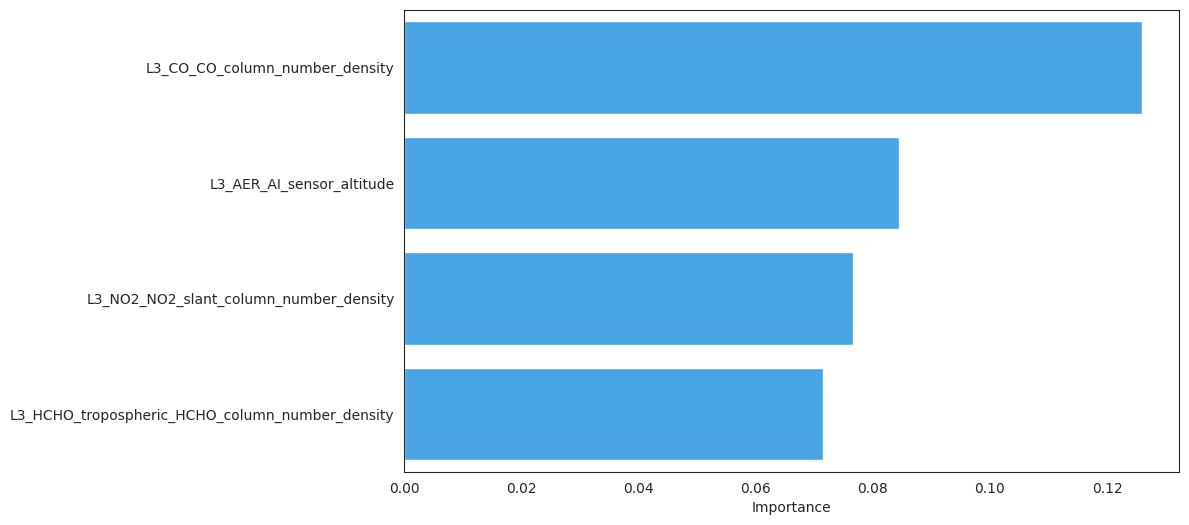

In [21]:
filtered_feature_names = feature_names[importances > 0.04]
filtered_importances = importances[importances > 0.04]

sorted_indices = np.argsort(filtered_importances)[::-1]  
sorted_feature_names = filtered_feature_names[sorted_indices]
sorted_importances = filtered_importances[sorted_indices]


plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=['#2EA8FF'])

# Titel hinzufügen
plt.xlabel("Importance")
